In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from copy import deepcopy
from keras.models import Sequential, Model
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, GRU, Input
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.layers import LeakyReLU
from tensorflow.keras.losses import Loss
from keras import backend as K
import keras
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures

from poly_interpolation import PolyInter
from macd import Ema    
# df = yf.Ticker('XOM').history(period="max", interval='1wk')
# # df['Close_dif'] = df['Close'].diff()
# df = df.dropna().iloc[:, :4]
# for i in df.columns: df = df[df[i] != 0]

def matrix_2d(x: np.array, timestemp: int) -> list:
    x = deepcopy(x)
    reshaped_x = []
    for i in range(timestemp, x.shape[0] + 1):
        reshaped_x.append(np.array([i[0] for i in x[i - timestemp:i]]))
    return np.array(reshaped_x)

In [33]:
df = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/df.csv')
df = df.set_index('Date')
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_1/data_scaler/target.csv')
# df['target_1'] = target['Close'].values
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_2/data_scaler/target.csv')
# df['target_2'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_3/data_scaler/target.csv')
# df['target_3'] = target['Close_Ema_5_diff'].values
# df = df.iloc[:-1, :]
# target = pd.read_csv('../data/premodel/XOM/1-set/time_ahead_4/data_scaler/target.csv')
# df['target_4'] = target['Close_Ema_5_diff'].values
# df.head(3)

# ax = df.corr()['target_1'].sort_values()
# df.loc[:, ['target_1', 'Close_Ema_9_diff', 'Close_Ema_5_diff', 'trend_macd_diff']].corr()
df.columns

Index(['Close'], dtype='object')

Interpolation progress: 100.00%
Interpolation progress: 9.00%

/home/magico/Main/Projects/market-data-pipe/notebooks/poly_interpolation.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pred_inter)


Interpolation progress: 100.00%


/home/magico/Main/Projects/market-data-pipe/notebooks/poly_interpolation.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pred_inter)


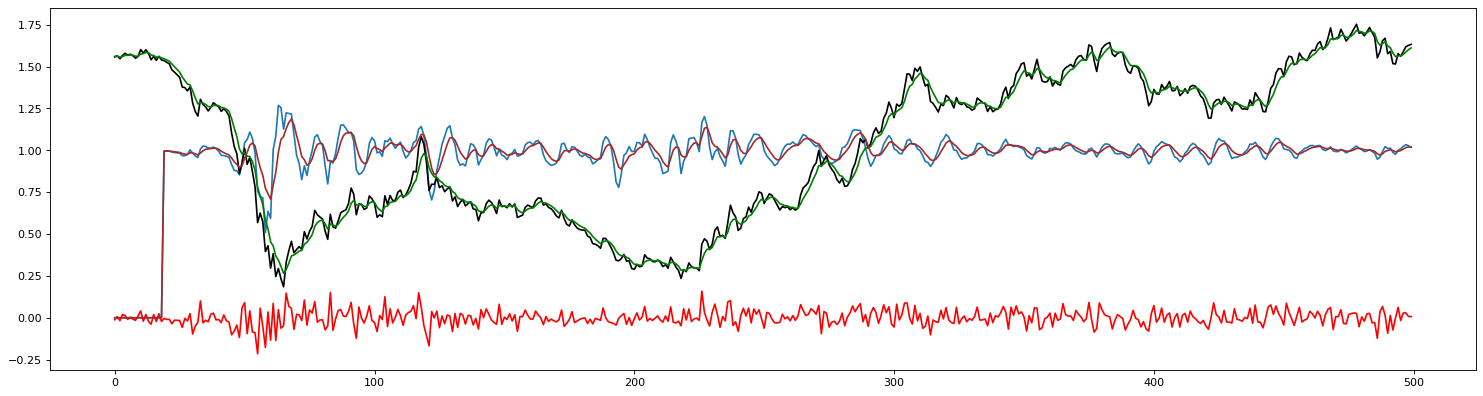

In [104]:
size = -500
x = df.loc[:, ['Close']].reset_index(drop='index').values[size:]
poly = PolyInter(x, {"degree":4, "pd":20, "plot":False, "progress_bar":True}).get_values()
ema_5 = Ema(x, {"period":5}).get_values()
poly_ema = PolyInter(ema_5, {"degree":4, "pd":20, "plot":False, "progress_bar":True}).get_values()

figure(figsize=(23, 6), dpi=80)
plt.plot(poly)
plt.plot(x, color='black')
plt.plot(np.diff(df['Close'].values[size - 1:]), color='red')
# plt.plot(ema_5, color='green')
# plt.plot(ema_9, color='green')
plt.plot(ema_5, color='green')
plt.plot(poly_ema, color='brown')

In [87]:
p = PolyInter(df.loc[:, ['Close']].reset_index(drop='index').values, d).get_values()

Interpolation progress: 100.00%


/home/magico/Main/Projects/market-data-pipe/notebooks/poly_interpolation.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pred_inter)


/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.998288053311476
0.8300010091582822
0.004839510405324334
0.0357038534623532


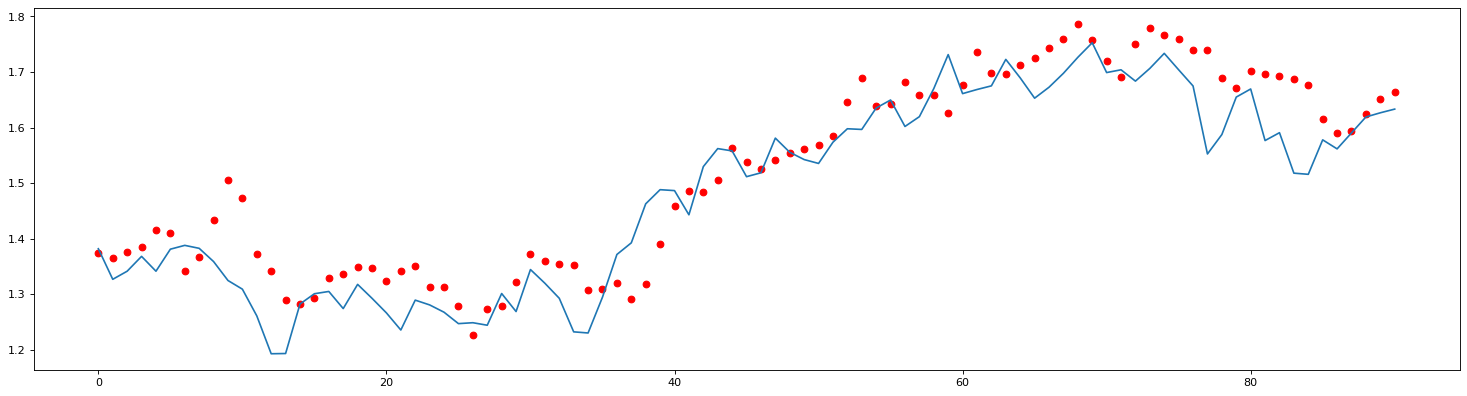

/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.998546990944482
0.8247822516381444
0.004988077353848673
0.03575744748079312


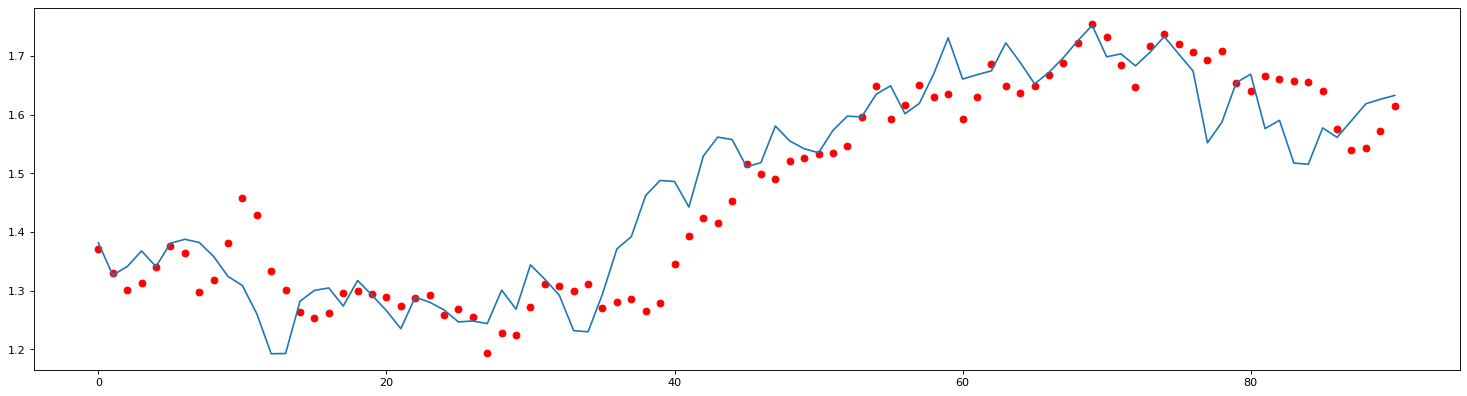

/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9981834048239236
0.7737107163825172
0.0064419755509010496
0.04211870294365978


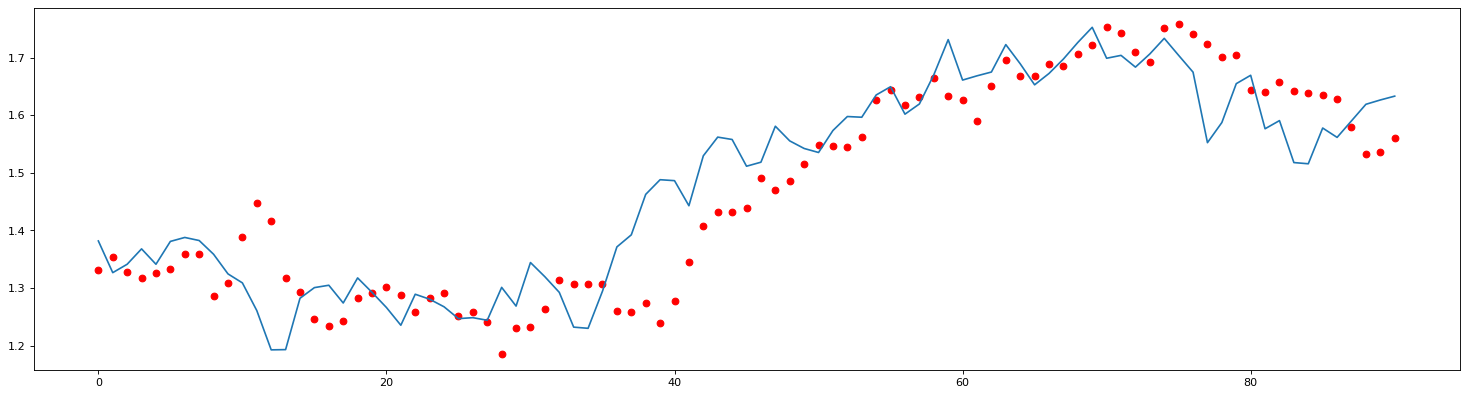

/home/magico/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.9969550982196688
0.6891385176428784
0.008849566524089346
0.04649098446764156


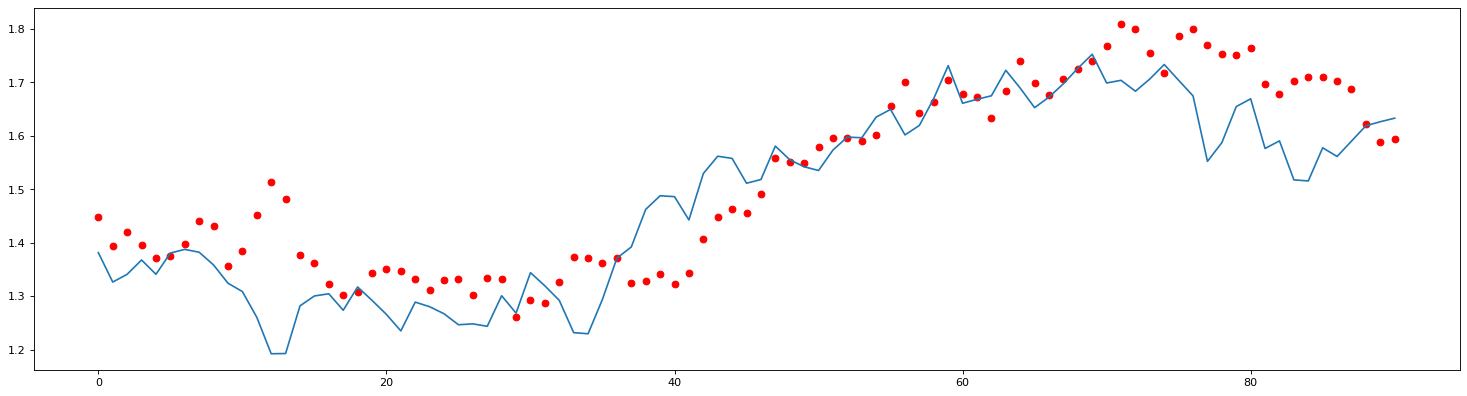

In [90]:
def regressor(tah):
    X =  df.loc[:, ['Close']].reset_index(drop='index').values[:-tah]
    y =  df.loc[:, ['Close']].reset_index(drop='index').values[tah:]

    x_2d = matrix_2d(X[:-150], 60)
    y_ax = y[:-150][59:]

    X_train, x_test, y_train, y_test = train_test_split(x_2d, y_ax, test_size=0.33, random_state=42)
    regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
    print(regr.score(x_test, y_test))

    x_2d = matrix_2d(X[-150:], 60)
    y_ax = y[-150:][59:]

    pred = regr.predict(x_2d)

    print(regr.score(x_2d, y_ax))
    print(mean_squared_error(pred, y_ax))
    print(mean_absolute_percentage_error(pred, y_ax))
    figure(figsize=(23, 6), dpi=80)
    plt.plot(y_ax)
    plt.scatter(range(y_ax.shape[0]), pred, color='red')
    plt.show()


regressor(1)
regressor(2)
regressor(3)
regressor(4)

In [ ]:
def regression(X, y) -> None:
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        model = Sequential()

        model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.20))

        model.add(LSTM(64, return_sequences=False, activation='tanh'))
        model.add(Dropout(0.20))

        model.add(Dense(12, activation='tanh'))
        model.add(Dense(12, activation='tanh'))
        model.add(Dense(12, activation='tanh'))
        model.add(Dense(1))

        model.compile(loss='mse', optimizer=Adam(learning_rate=0.005), metrics=['mean_absolute_percentage_error'])
        model.fit(x_train, y_train, epochs=3, batch_size=1200, shuffle=True, validation_data=(x_test, y_test), verbose=1)


# X = df.loc[:, ['Close', 'Close_Ema_5_diff']].reset_index(drop='index').values
# y = df.loc[:, ['target_1']].reset_index(drop='index').values

X =  df.loc[:, ['Close_Ema_5']].reset_index(drop='index').values[:-1]
y =  df.loc[:, ['Close_Ema_5']].reset_index(drop='index').values[1:]

def matrix_3d(x: np.array, timestemp: int) -> list:
    x = deepcopy(x)
    reshaped_x = []
    for i in range(timestemp, x.shape[0] + 1):
        reshaped_x.append(x[i - timestemp:i])
    return np.array(reshaped_x)


X_3d = matrix_3d(X, 1)
y_ax = y[63:]
# regression(X_3d, y_ax)

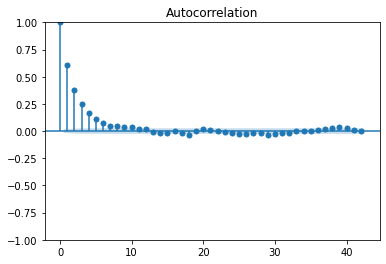

count    12993.000000
mean         0.000648
std          1.003131
min        -12.664792
25%         -0.092077
50%         -0.019866
75%          0.142560
max          7.884919
Name: Close_Ema_5_diff, dtype: float64


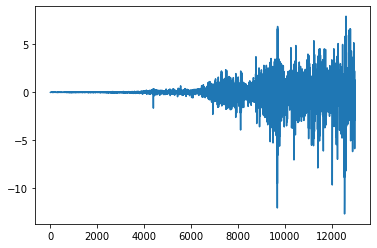

In [21]:
plot_acf(df['Close_Ema_5_diff'])
plt.show()
# print(df.corr()['Close_Ema_5_diff'].sort_values())
print(df['Close_Ema_5_diff'].describe())
# df['Close_Ema_5_diff'].hist()
plt.plot(df['Close_Ema_5_diff'].values)

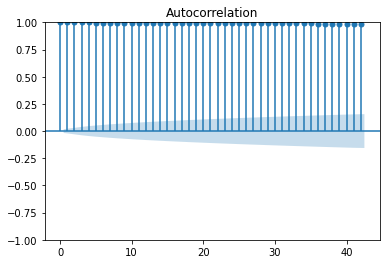

count    12993.000000
mean         0.006486
std          1.000455
min         -0.907489
25%         -0.874505
50%         -0.527235
75%          0.897540
max          2.174612
Name: Close, dtype: float64


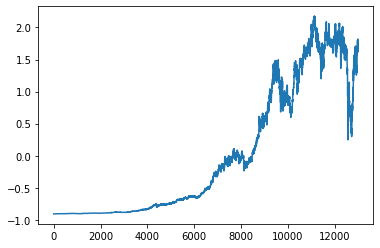

In [26]:
plot_acf(df['Close'])
plt.show()
# print(df.corr()['Close'].sort_values())
print(df['Close'].describe())
# df['Close'].hist()
plt.plot(df['Close'].values)